In [ ]:
#| hide
#|eval: false
# This is to render Plotly plots into HTML
# For more information, see https://quarto.org/docs/interactive/widgets/jupyter.html#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# Statistical, Machine Learning and Neural Forecasting methods

> In this notebook, you will make forecasts for the M5 dataset choosing the best model for each time series using cross validation.

- skip_showdoc: true
- skip_exec: true


Statistical, Machine Learning, and Neural Forecasting Methods
In this tutorial, we will explore the process of forecasting on the M5 dataset by utilizing the most suitable model for each time series. We'll accomplish this through an essential technique known as cross-validation. This approach helps us in estimating the predictive performance of our models, and in selecting the model that yields the best performance for each time series.

The M5 dataset comprises of hierarchical sales data, spanning five years, from Walmart. The aim is to forecast daily sales for the next 28 days. The dataset is broken down into the 50 states of America, with 10 stores in each state.

In the realm of time series forecasting and analysis, one of the more complex tasks is identifying the model that is optimally suited for a specific group of series. Quite often, this selection process leans heavily on intuition, which may not necessarily align with the empirical reality of our dataset.

In this tutorial, we aim to provide a more structured, data-driven approach to model selection for different groups of series within the M5 benchmark dataset. This dataset, well-known in the field of forecasting, allows us to showcase the versatility and power of our methodology.

We will train an assortment of models from various forecasting paradigms:

*[StatsForecast]((https://github.com/Nixtla/statsforecast))*

- Baseline models: These models are simple yet often highly effective for providing an initial perspective on the forecasting problem. We will use `SeasonalNaive` and `HistoricAverage` models for this category.
- Intermittent models: For series with sporadic, non-continuous demand, we will utilize models like `CrostonOptimized`, `IMAPA`, and `ADIDA`. These models are particularly suited for handling zero-inflated series.
- State Space Models: These are statistical models that use mathematical descriptions of a system to make predictions. The `AutoETS` model from the statsforecast library falls under this category.

*[MLForecast](https://github.com/Nixtla/mlforecast)*

Machine Learning: Leveraging ML models like `LightGBM`, `XGBoost`, and `LinearRegression` can be advantageous due to their capacity to uncover intricate patterns in data. We'll use the MLForecast library for this purpose.

*[NeuralForecast](https://github.com/Nixtla/neuralforecast)*

Deep Learning: DL models, such as Transformers (`AutoTFT`) and Neural Networks (`AutoNHITS`), allow us to handle complex non-linear dependencies in time series data. We'll utilize the NeuralForecast library for these models.

Using the Nixtla suite of libraries, we'll be able to drive our model selection process with data, ensuring we utilize the most suitable models for specific groups of series in our dataset.

Outline:

* Reading Data: In this initial step, we load our dataset into memory, making it available for our subsequent analysis and forecasting. It is important to understand the structure and nuances of the dataset at this stage.

* Forecasting Using Statistical and Deep Learning Methods: We apply a wide range of forecasting methods from basic statistical techniques to advanced deep learning models. The aim is to generate predictions for the next 28 days based on our dataset.

* Model Performance Evaluation on Different Windows: We assess the performance of our models on distinct windows.

* Selecting the Best Model for a Group of Series: Using the performance evaluation, we identify the optimal model for each group of series. This step ensures that the chosen model is tailored to the unique characteristics of each group.

* Filtering the Best Possible Forecast: Finally, we filter the forecasts generated by our chosen models to obtain the most promising predictions. This is our final output and represents the best possible forecast for each series according to our models.

::: {.callout-warning collapse="false"}
This tutorial was originally executed using a `c5d.24xlarge` EC2 instance.
:::

## Installing Libraries

```sh
!pip install statsforecast mlforecast neuralforecast datasetforecast s3fs pyarrow
```

## Download and prepare data

The example uses the [M5 dataset](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf). It consists of `30,490` bottom time series. 

In [ ]:
import pandas as pd

In [ ]:
# Load the training target dataset from the provided URL
Y_df = pd.read_parquet('../Data/target.parquet')
#Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')

# Rename columns to match the Nixtlaverse's expectations
# The 'item_id' becomes 'unique_id' representing the unique identifier of the time series
# The 'timestamp' becomes 'ds' representing the time stamp of the data points
# The 'demand' becomes 'y' representing the target variable we want to forecast
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df['ds'] = pd.to_datetime(Y_df['ds'])


In [ ]:
Y_df

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0
...,...,...,...
46796215,HOUSEHOLD_2_516_WI_3,2016-05-18,0.0
46796216,HOUSEHOLD_2_516_WI_3,2016-05-19,0.0
46796217,HOUSEHOLD_2_516_WI_3,2016-05-20,0.0
46796218,HOUSEHOLD_2_516_WI_3,2016-05-21,0.0


For simplicity sake we will keep just one category

In [ ]:
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3_001")').reset_index(drop=True)

Y_df['unique_id'] = Y_df['unique_id'].astype(str)

In [ ]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18758 entries, 0 to 18757
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  18758 non-null  object        
 1   ds         18758 non-null  datetime64[ns]
 2   y          18758 non-null  float32       
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 366.5+ KB


In [ ]:
df = pd.DataFrame()
test = pd.DataFrame()
horizon = 28

for a in Y_df.unique_id.unique():
    length = len(Y_df.query(f'unique_id.str.startswith("{a}")'))
    df_sub = Y_df.query(f'unique_id.str.startswith("{a}")')[:length - horizon]
    test_sub = Y_df.query(f'unique_id.str.startswith("{a}")')[length - 2 * horizon:]
    df = pd.concat([df, df_sub], ignore_index=True)
    test = pd.concat([test, test_sub], ignore_index=True)
    
    newlength = len(df.query(f'unique_id.str.startswith("{a}")'))
    print(f'{a} : {length} and {newlength}')

FOODS_3_001_CA_1 : 1941 and 1913
FOODS_3_001_CA_2 : 1936 and 1908
FOODS_3_001_CA_3 : 1941 and 1913
FOODS_3_001_CA_4 : 1936 and 1908
FOODS_3_001_TX_1 : 1940 and 1912
FOODS_3_001_TX_2 : 1938 and 1910
FOODS_3_001_TX_3 : 1940 and 1912
FOODS_3_001_WI_1 : 1305 and 1277
FOODS_3_001_WI_2 : 1940 and 1912
FOODS_3_001_WI_3 : 1941 and 1913


# Basic Plotting

Plot some series using the plot method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic [EDA](https://nixtla.github.io/statsforecast/core.html#statsforecast.plot).


In [ ]:
from statsforecast import StatsForecast

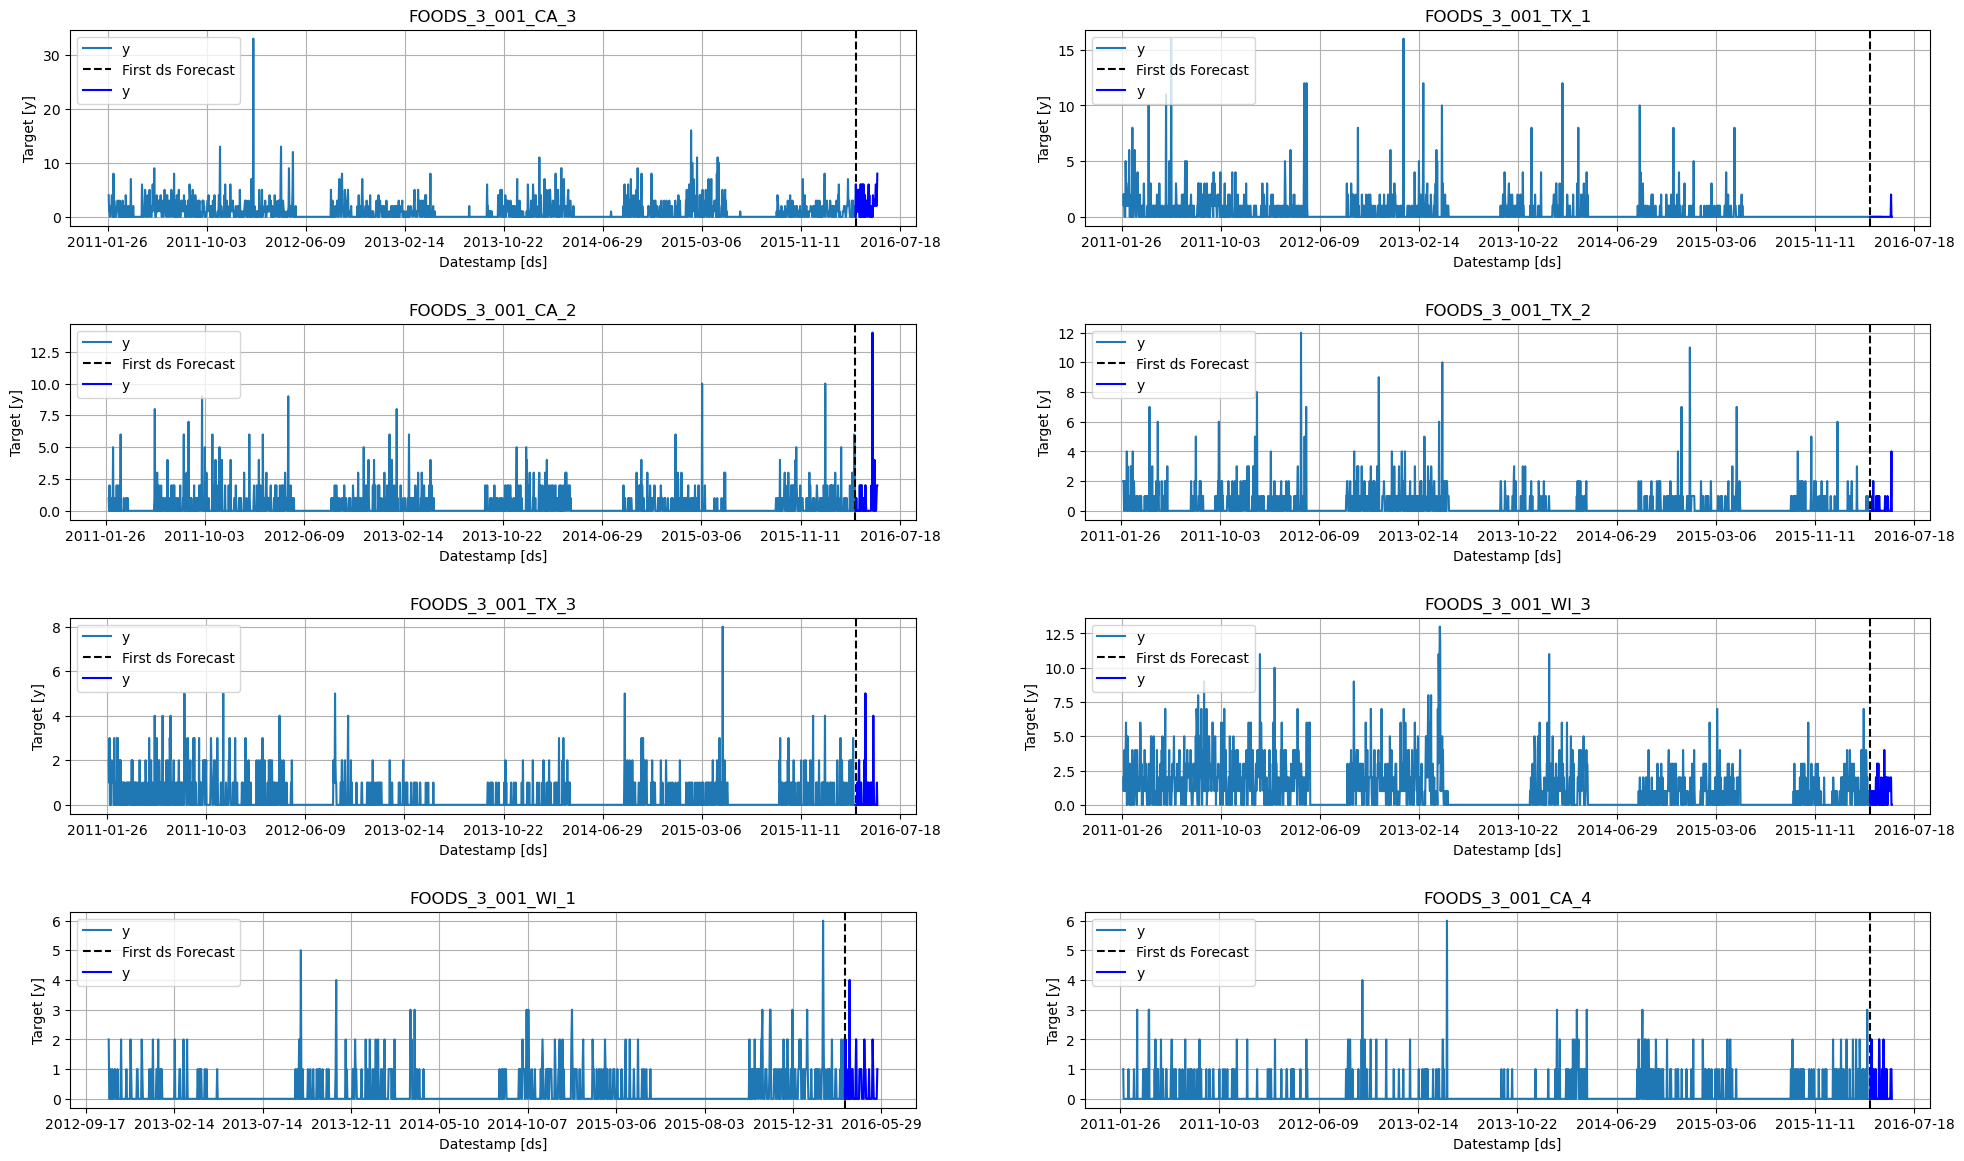

In [ ]:
# Feature: plot random series for EDA
StatsForecast.plot(df, test)


# Create forecasts with Stats, Ml and Neural methods.

## StatsForecast

`StatsForecast` is a comprehensive library providing a suite of popular univariate time series forecasting models, all designed with a focus on high performance and scalability.

Here's what makes StatsForecast a powerful tool for time series forecasting:

- **Collection of Local Models**: StatsForecast provides a diverse collection of local models that can be applied to each time series individually, allowing us to capture unique patterns within each series.

- **Simplicity**: With StatsForecast, training, forecasting, and backtesting multiple models become a straightforward process, requiring only a few lines of code. This simplicity makes it a convenient tool for both beginners and experienced practitioners.

- **Optimized for Speed**: The implementation of the models in StatsForecast is optimized for speed, ensuring that large-scale computations are performed efficiently, thereby reducing the overall time for model training and prediction.

- **Horizontal Scalability**: One of the distinguishing features of StatsForecast is its ability to scale horizontally. It is compatible with distributed computing frameworks such as Spark, Dask, and Ray. This feature allows it to handle large datasets by distributing the computations across multiple nodes in a cluster, making it a go-to solution for large-scale time series forecasting tasks.

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

In [ ]:
# Import necessary models from the statsforecast library
from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)
from statsforecast.utils import ConformalIntervals

/home/ben/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


We fit the models by instantiating a new StatsForecast object with the following parameters:

- `models`: a list of models. Select the models you want from models and import them.
- `freq`: a string indicating the frequency of the data. (See panda’s available frequencies.)
- `n_jobs`: int, number of jobs used in the parallel processing, use -1 for all cores.
- `fallback_model`: a model to be used if a model fails.
Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
intervals = ConformalIntervals(h=horizon, n_windows=2)
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

In [ ]:
# Instantiate the StatsForecast class
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='D',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=10,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
    verbose = True
)


The forecast method takes two arguments: forecasts next h (horizon) and level.

- `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This block of code times how long it takes to run the forecasting function of the StatsForecast class, which predicts the next 28 days (h=28). The level is set to [90], meaning it will compute the 90% prediction interval. The time is calculated in minutes and printed out at the end.

In [ ]:
from time import time

# Get the current time before forecasting starts, this will be used to measure the execution time
init = time()

# Call the forecast method of the StatsForecast instance to predict the next 28 days (h=28) 
# Level is set to [90], which means that it will compute the 90% prediction interval
fcst_df = sf.forecast(df=df, 
                      h=horizon,
                      level=[90],
                      prediction_intervals=intervals
                     )

# Get the current time after the forecasting ends
end = time()

# Calculate and print the total time taken for the forecasting in minutes
print(f'Forecast Minutes: {(end - init) / 60}')
#Forecast Minutes: 0.7311509331067403


Forecast Minutes: 0.8084765871365865


In [ ]:
fcst_df.head()

,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,...,CrostonOptimized-hi-90,ADIDA,ADIDA-lo-90,ADIDA-hi-90,IMAPA,IMAPA-lo-90,IMAPA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001_CA_1,2016-04-25,2.0,0.00,4.00,1.0,0.00,2.00,0.452692,0.000000,0.905384,...,1.107222,0.56904,0.000000,1.138079,0.555747,0.000000,1.111494,0.611209,-1.015629e-08,1.222419
FOODS_3_001_CA_1,2016-04-26,0.0,-0.85,0.85,1.0,0.15,1.85,0.452692,-0.080423,0.985808,...,1.091138,0.56904,0.020712,1.117367,0.555747,0.016724,1.094770,0.519098,5.729341e-03,1.032466
FOODS_3_001_CA_1,2016-04-27,0.0,-0.85,0.85,1.0,0.15,1.85,0.452692,-0.080423,0.985808,...,1.091138,0.56904,0.020712,1.117367,0.555747,0.016724,1.094770,0.567324,2.019713e-02,1.114451
FOODS_3_001_CA_1,2016-04-28,1.0,0.15,1.85,1.0,0.15,1.85,0.452692,-0.080423,0.985808,...,1.091138,0.56904,0.020712,1.117367,0.555747,0.016724,1.094770,0.410421,-1.522845e-01,0.973126
FOODS_3_001_CA_1,2016-04-29,0.0,0.00,0.00,1.0,0.00,2.00,0.452692,0.000000,0.905384,...,1.107222,0.56904,0.000000,1.138079,0.555747,0.000000,1.111494,0.540213,-3.345982e-09,1.080427


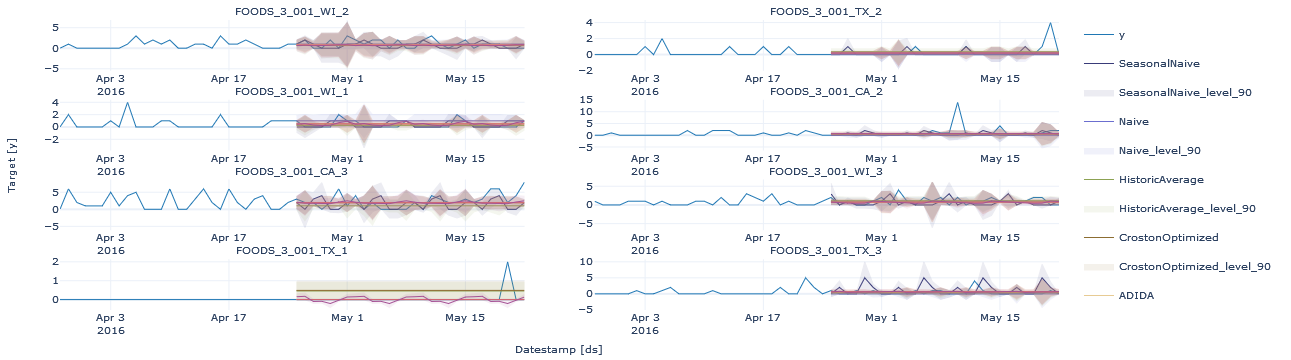

In [ ]:
StatsForecast.plot(test, fcst_df, engine = 'plotly')

## MLForecast

`MLForecast` is a powerful library that provides automated feature creation for time series forecasting, facilitating the use of global machine learning models. It is designed for high performance and scalability.

Key features of MLForecast include:

* **Support for sklearn models**: MLForecast is compatible with models that follow the scikit-learn API. This makes it highly flexible and allows it to seamlessly integrate with a wide variety of machine learning algorithms.

* **Simplicity**: With MLForecast, the tasks of training, forecasting, and backtesting models can be accomplished in just a few lines of code. This streamlined simplicity makes it user-friendly for practitioners at all levels of expertise.

* **Optimized for speed:** MLForecast is engineered to execute tasks rapidly, which is crucial when handling large datasets and complex models.

* **Horizontal Scalability:** MLForecast is capable of horizontal scaling using distributed computing frameworks such as Spark, Dask, and Ray. This feature enables it to efficiently process massive datasets by distributing the computations across multiple nodes in a cluster, making it ideal for large-scale time series forecasting tasks.

In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean

```sh
!pip install lightgbm xgboost
```

In [ ]:
# Import the necessary models from various libraries

# LGBMRegressor: A gradient boosting framework that uses tree-based learning algorithms from the LightGBM library
from lightgbm import LGBMRegressor

# XGBRegressor: A gradient boosting regressor model from the XGBoost library
from xgboost import XGBRegressor

# LinearRegression: A simple linear regression model from the scikit-learn library
from sklearn.linear_model import LinearRegression


In [ ]:
# Instantiate the MLForecast object
mlf = MLForecast(
    models=[LGBMRegressor(), XGBRegressor(), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='D',  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 7)),  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms = {
        1:  [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],  # Date features to use as regressors
)


Just call the `fit` models to train the select models. In this case we are generating conformal prediction intervals. 

In [ ]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(df, prediction_intervals=PredictionIntervals(h=horizon, n_windows=2))

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 17858, number of used features: 13
[LightGBM] [Info] Start training from score 0.526375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 18418, number of used features: 13
[LightGBM] [Info] Start training from score 0.531328
MLForecast Minutes: 0.06777082284291586


After that, just call `predict` to generate forecasts.

In [ ]:
fcst_mlf_df = mlf.predict(horizon,
                          #level=[90]
                         )

In [ ]:
fcst_mlf_df.head()

,unique_id,ds,LGBMRegressor,XGBRegressor,LinearRegression
0,FOODS_3_001_CA_1,2016-04-25,0.810128,0.099661,0.122907
1,FOODS_3_001_CA_1,2016-04-26,0.881765,0.062783,0.140931
2,FOODS_3_001_CA_1,2016-04-27,0.462391,-0.064804,0.167513
3,FOODS_3_001_CA_1,2016-04-28,0.453431,-0.084136,0.199248
4,FOODS_3_001_CA_1,2016-04-29,0.376807,0.018470,0.223721


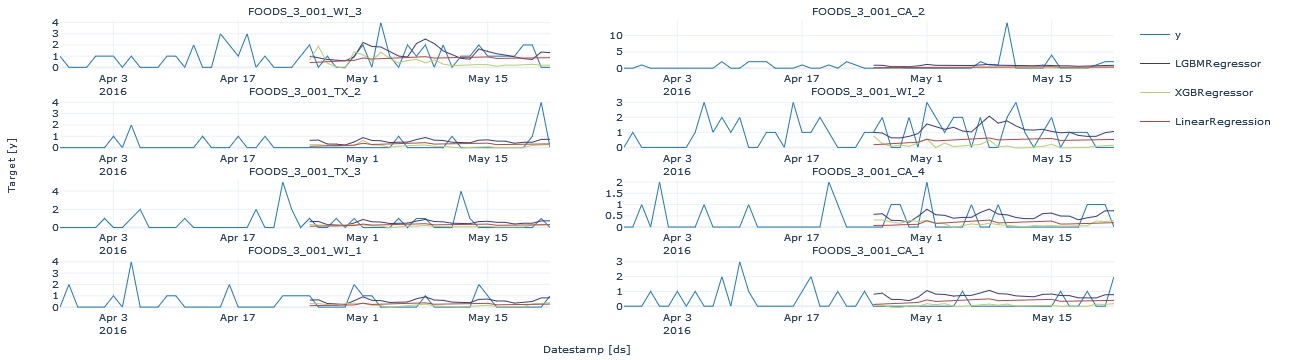

In [ ]:
StatsForecast.plot(test, fcst_mlf_df, engine = 'plotly')


## NeuralForecast

`NeuralForecast` is a robust collection of neural forecasting models that focuses on usability and performance. It includes a variety of model architectures, from classic networks such as Multilayer Perceptrons (MLP) and Recurrent Neural Networks (RNN) to novel contributions like N-BEATS, N-HITS, Temporal Fusion Transformers (TFT), and more.

Key features of `NeuralForecast` include:

- A broad collection of global models. Out of the box implementation of MLP, LSTM, RNN, TCN, DilatedRNN, NBEATS, NHITS, ESRNN, TFT, Informer, PatchTST and HINT. 
- A simple and intuitive interface that allows training, forecasting, and backtesting of various models in a few lines of code.
- Support for GPU acceleration to improve computational speed.


This machine doesn't have GPU, but Google Colabs offers some for free. 

Using [Colab's GPU to train NeuralForecast](https://nixtla.github.io/neuralforecast/examples/intermittentdata.html).


In [ ]:
# Read the results from Colab
fcst_nf_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/forecast-nf.parquet')
#Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')


In [ ]:
fcst_nf_df.head()

,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-hi-90,AutoTFT,AutoTFT-lo-90,AutoTFT-hi-90
0,FOODS_3_001_CA_1,2016-05-23,0.0,0.0,2.0,0.0,0.0,2.0
1,FOODS_3_001_CA_1,2016-05-24,0.0,0.0,2.0,0.0,0.0,2.0
2,FOODS_3_001_CA_1,2016-05-25,0.0,0.0,2.0,0.0,0.0,1.0
3,FOODS_3_001_CA_1,2016-05-26,0.0,0.0,2.0,0.0,0.0,2.0
4,FOODS_3_001_CA_1,2016-05-27,0.0,0.0,2.0,0.0,0.0,2.0


In [ ]:
# Merge the forecasts from StatsForecast and NeuralForecast
fcst_df = fcst_df.merge(fcst_nf_df, how='left', on=['unique_id', 'ds'])

# Merge the forecasts from MLForecast into the combined forecast dataframe
fcst_df = fcst_df.merge(fcst_mlf_df, how='left', on=['unique_id', 'ds'])


In [ ]:
fcst_df.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,...,AutoETS-hi-90,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-hi-90,AutoTFT,AutoTFT-lo-90,AutoTFT-hi-90,LGBMRegressor,XGBRegressor,LinearRegression
0,FOODS_3_001_CA_1,2016-04-25,2.0,0.00,4.00,1.0,0.00,2.00,0.452692,0.000000,...,1.222419,NaN,NaN,NaN,NaN,NaN,NaN,0.810128,0.099661,0.122907
1,FOODS_3_001_CA_1,2016-04-26,0.0,-0.85,0.85,1.0,0.15,1.85,0.452692,-0.080423,...,1.032466,NaN,NaN,NaN,NaN,NaN,NaN,0.881765,0.062783,0.140931
2,FOODS_3_001_CA_1,2016-04-27,0.0,-0.85,0.85,1.0,0.15,1.85,0.452692,-0.080423,...,1.114451,NaN,NaN,NaN,NaN,NaN,NaN,0.462391,-0.064804,0.167513
3,FOODS_3_001_CA_1,2016-04-28,1.0,0.15,1.85,1.0,0.15,1.85,0.452692,-0.080423,...,0.973126,NaN,NaN,NaN,NaN,NaN,NaN,0.453431,-0.084136,0.199248
4,FOODS_3_001_CA_1,2016-04-29,0.0,0.00,0.00,1.0,0.00,2.00,0.452692,0.000000,...,1.080427,NaN,NaN,NaN,NaN,NaN,NaN,0.376807,0.018470,0.223721


## Forecast plots

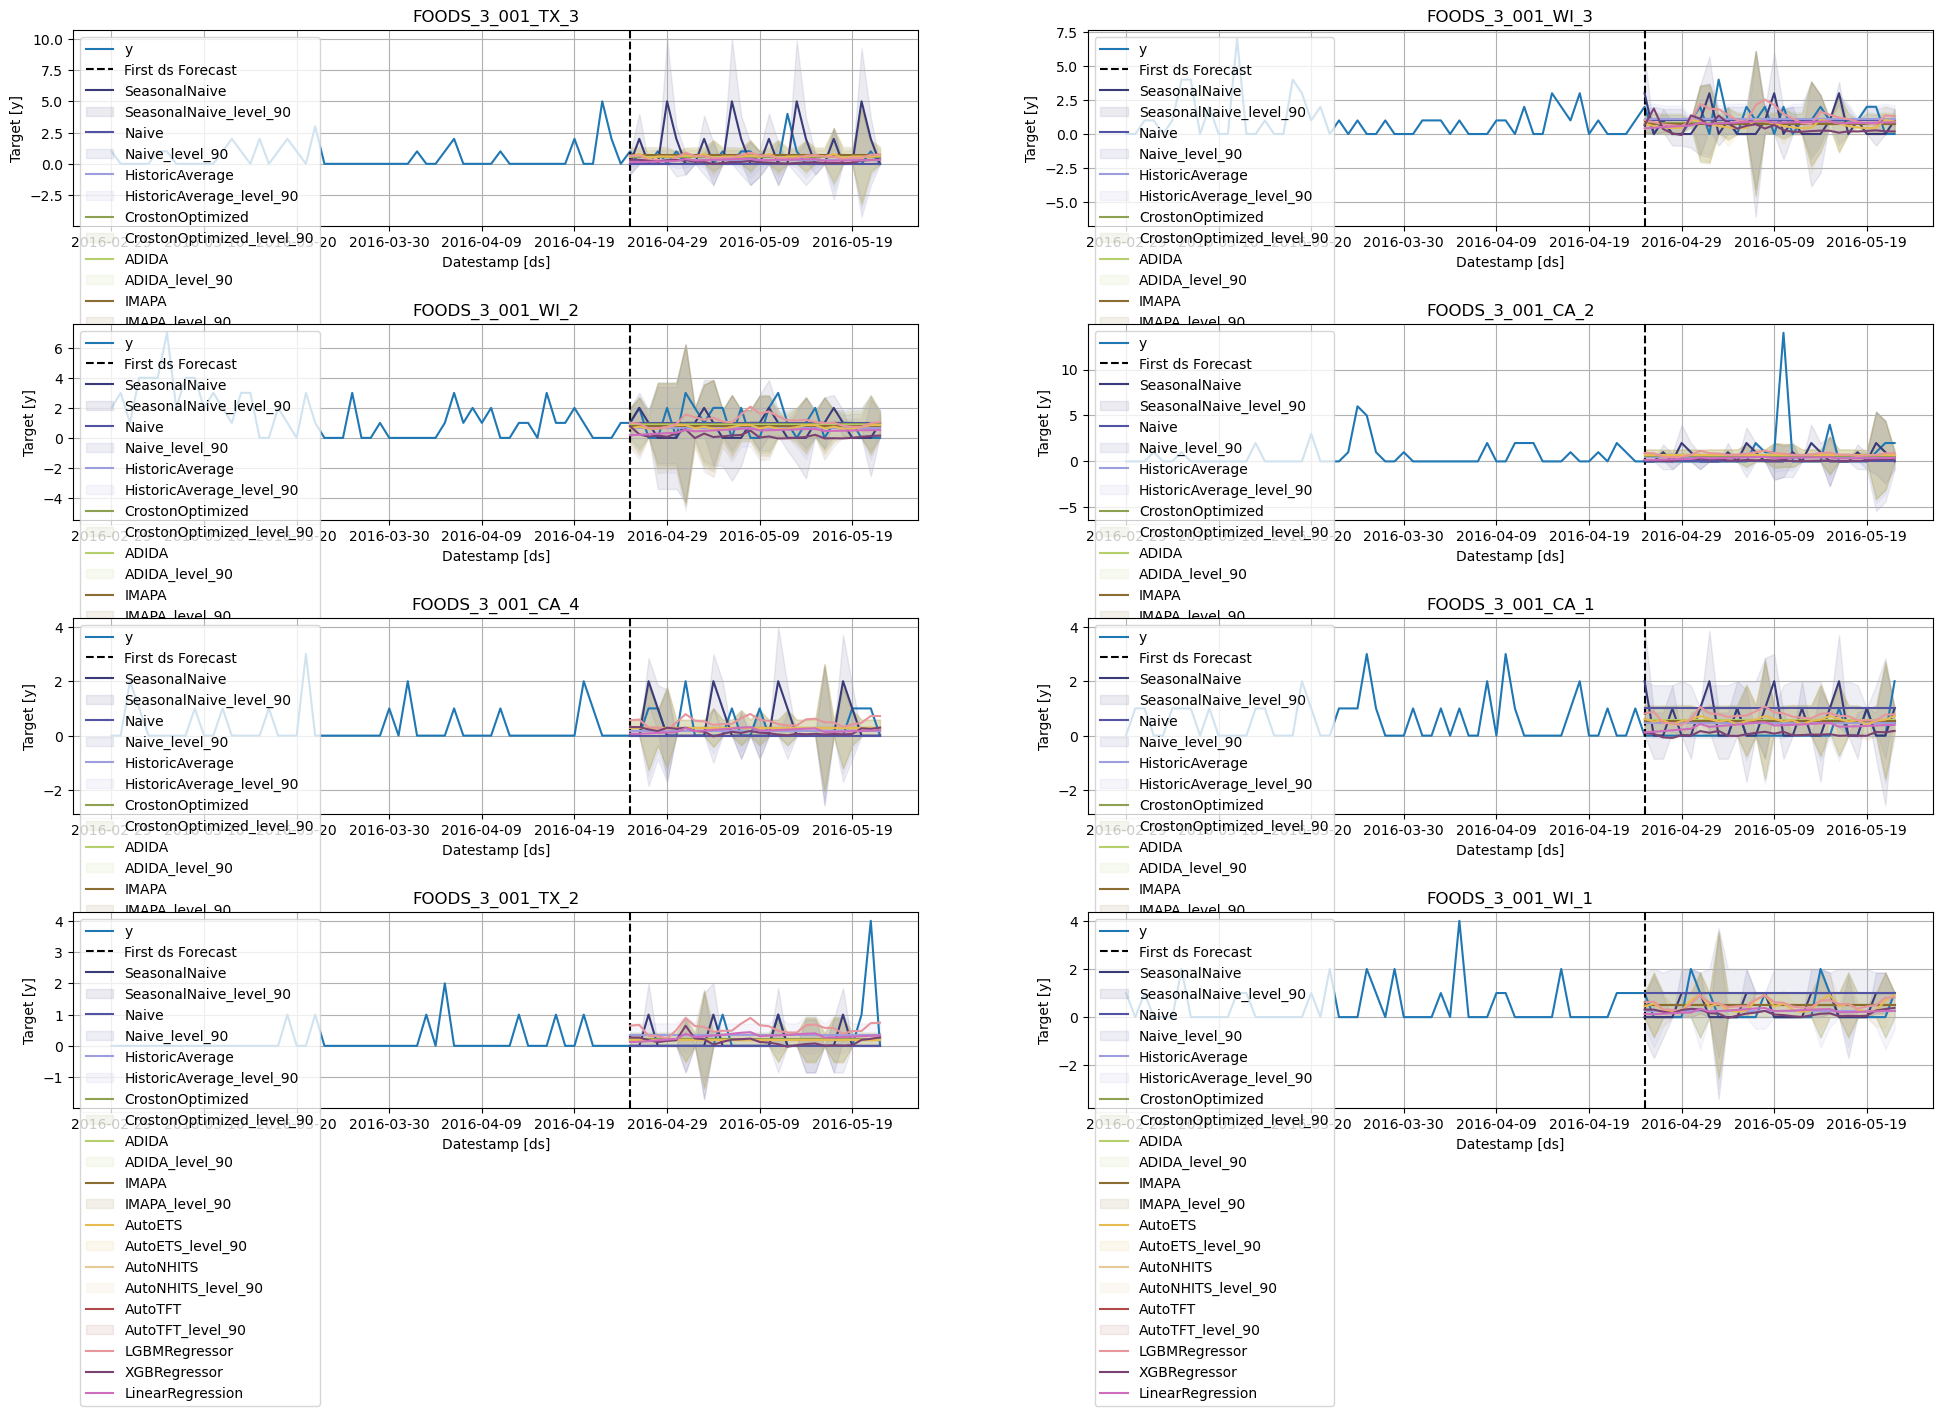

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

Use the plot function to explore models and ID's

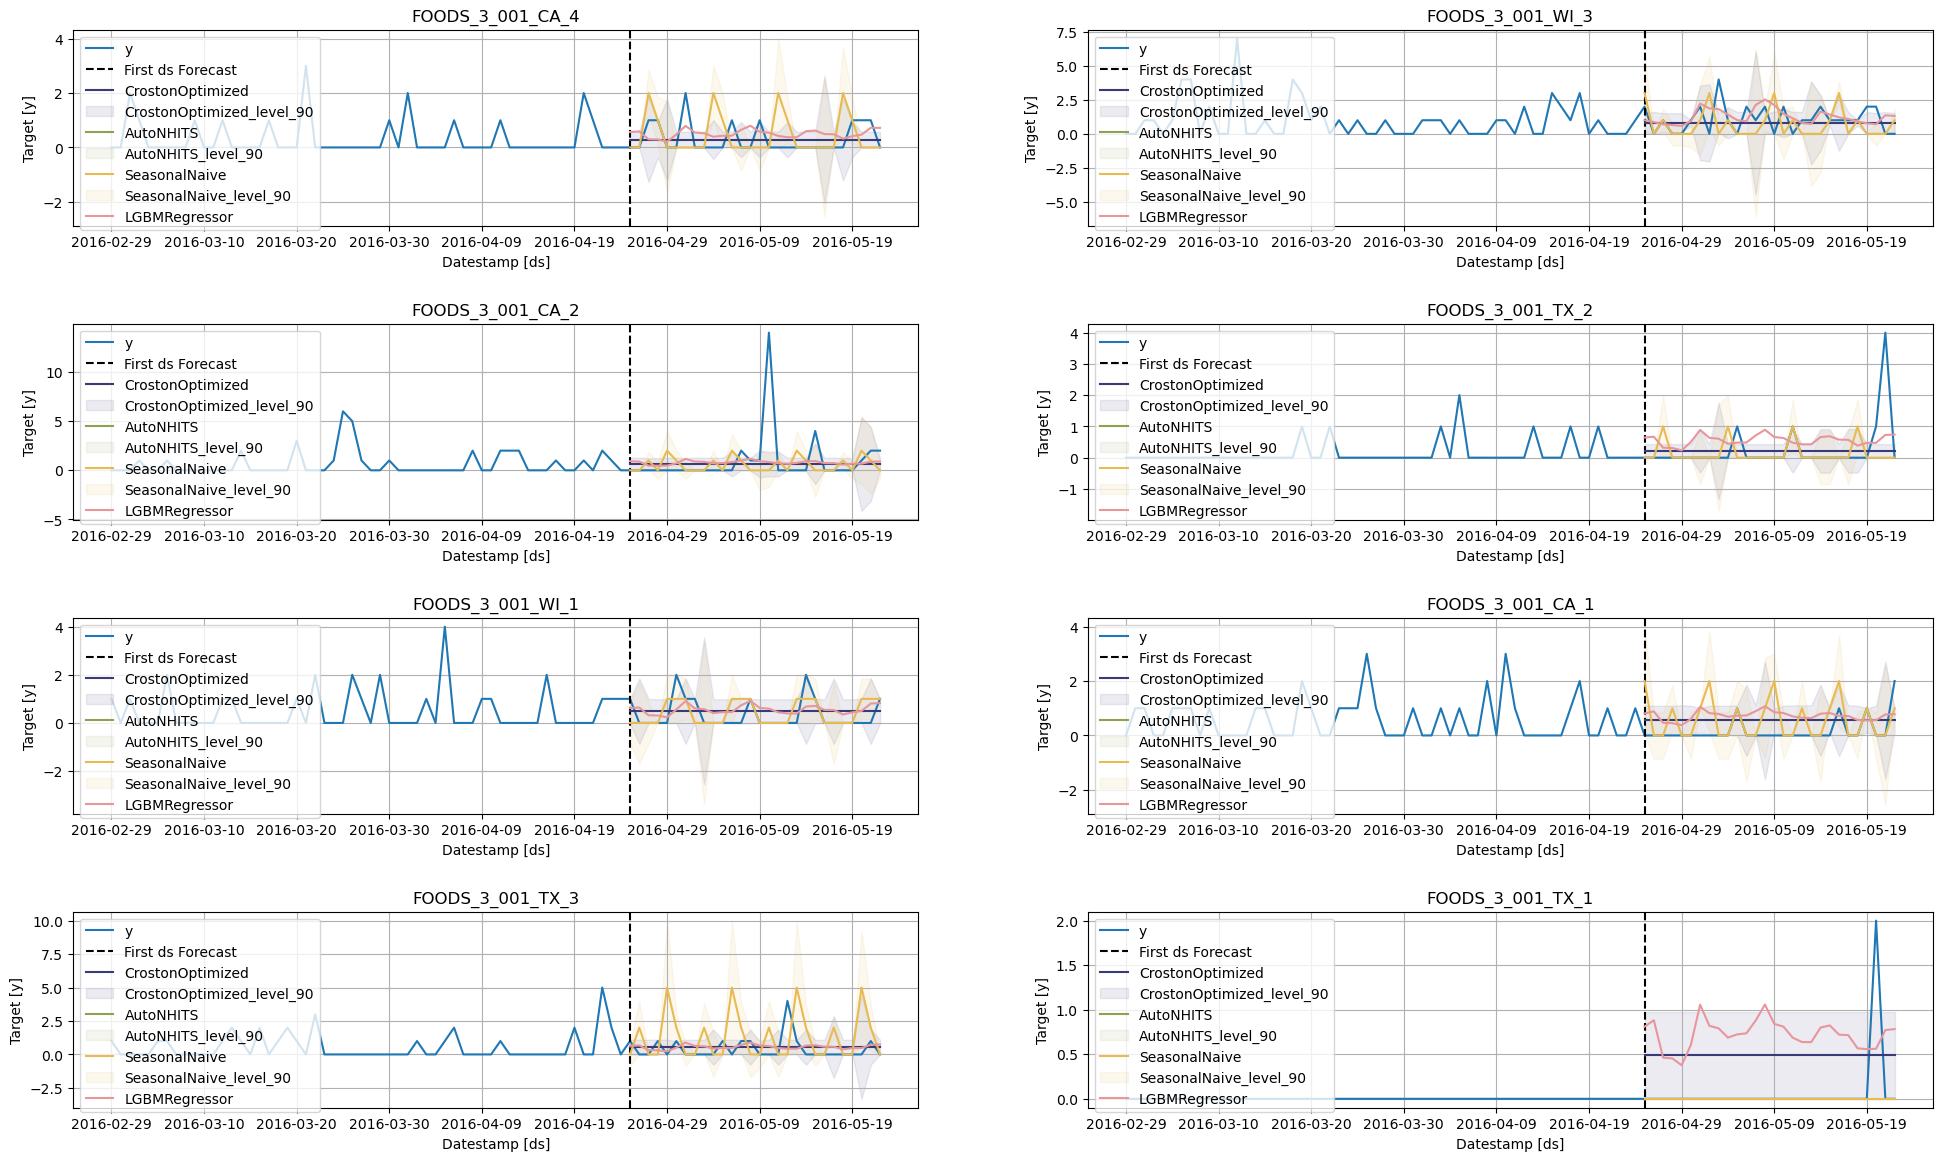

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3, 
        models=['CrostonOptimized', 'AutoNHITS', 'SeasonalNaive', 'LGBMRegressor'])

# Validate Model's Performance

The three libraries - `StatsForecast`, `MLForecast`, and `NeuralForecast` - offer out-of-the-box cross-validation capabilities specifically designed for time series. This allows us to evaluate the model's performance using historical data to obtain an unbiased assessment of how well each model is likely to perform on unseen data.



![From the course of Modern Forecasting in Practice](../imgs/cv-sphere.png)

## Cross Validation in StatsForecast

The `cross_validation` method from the `StatsForecast` class accepts the following arguments:

- `df`: A DataFrame representing the training data.
- `h` (int): The forecast horizon, represented as the number of steps into the future that we wish to predict. For example, if we're forecasting hourly data, `h=24` would represent a 24-hour forecast.
- `step_size` (int): The step size between each cross-validation window. This parameter determines how often we want to run the forecasting process.
- `n_windows` (int): The number of windows used for cross validation. This parameter defines how many past forecasting processes we want to evaluate.

These parameters allow us to control the extent and granularity of our cross-validation process. By tuning these settings, we can balance between computational cost and the thoroughness of the cross-validation.


In [ ]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
end = time()
print(f'CV Minutes: {(end - init) / 60}')

CV Minutes: 1.091424548625946


The crossvaldation_df object is a new data frame that includes the following columns:

- `unique_id` index: (If you dont like working with index just run forecasts_cv_df.resetindex())
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
cv_df.head()

,ds,cutoff,y,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,...,CrostonOptimized-hi-90,ADIDA,ADIDA-lo-90,ADIDA-hi-90,IMAPA,IMAPA-lo-90,IMAPA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.0,2.0,0.15,3.85,0.0,-0.85,0.85,0.449111,...,1.201402,0.618375,0.035513,1.201238,0.617998,0.035399,1.200596,0.655286,4.658565e-02,1.263985
FOODS_3_001_CA_1,2016-03-01,2016-02-28,1.0,0.0,-1.70,1.70,0.0,-1.70,1.70,0.449111,...,1.885541,0.618375,-0.648762,1.885513,0.617998,-0.649404,1.885399,0.568595,-7.333890e-01,1.870578
FOODS_3_001_CA_1,2016-03-02,2016-02-28,1.0,0.0,-1.85,1.85,0.0,-1.85,1.85,0.449111,...,1.850000,0.618375,-0.613249,1.850000,0.617998,-0.614005,1.850000,0.618805,-6.123903e-01,1.850000
FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.0,1.0,0.00,2.00,0.0,0.00,0.00,0.449111,...,1.236943,0.618375,0.000000,1.236751,0.617998,0.000000,1.235995,0.455891,4.113969e-09,0.911781
FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.0,1.0,0.00,2.00,0.0,-1.70,1.70,0.449111,...,1.885541,0.618375,-0.648762,1.885513,0.617998,-0.649404,1.885399,0.591197,-6.949658e-01,1.877359


## MLForecast

The `cross_validation` method from the `MLForecast` class takes the following arguments.

- `data`: training data frame
- `window_size` (int): represents h steps into the future that are being forecasted. In this case, 24 hours ahead.
- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross-validation. In other words: what number of forecasting processes in the past do you want to evaluate.
- `prediction_intervals`: class to compute conformal intervals.

In [ ]:
init = time()
cv_mlf_df = mlf.cross_validation(
    df=Y_df, 
    h=horizon, 
    n_windows=3, 
    step_size=horizon, 
    level=[90],
)
end = time()
print(f'CV Minutes: {(end - init) / 60}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 17858, number of used features: 13
[LightGBM] [Info] Start training from score 0.526375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 18138, number of used features: 13
[LightGBM] [Info] Start training from score 0.530047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

The crossvaldation_df object is a new data frame that includes the following columns:

- `unique_id` index: (If you dont like working with index just run forecasts_cv_df.resetindex())
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
cv_mlf_df.head()

,unique_id,ds,cutoff,y,LGBMRegressor,XGBRegressor,LinearRegression
0,FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.0,0.476516,0.073750,0.103426
1,FOODS_3_001_CA_1,2016-03-01,2016-02-28,1.0,0.739830,0.035399,0.260099
2,FOODS_3_001_CA_1,2016-03-02,2016-02-28,1.0,0.586140,0.007563,0.296629
3,FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.0,0.536099,-0.004784,0.328724
4,FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.0,0.601544,-0.025531,0.371325


## NeuralForecast

This machine doesn't have GPU, but Google Colabs offers some for free. 

Using [Colab's GPU to train NeuralForecast](https://nixtla.github.io/neuralforecast/examples/intermittentdata.html).


In [ ]:
cv_nf_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/cross-validation-nf.parquet')

In [ ]:
cv_nf_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-hi-90,AutoTFT,AutoTFT-lo-90,AutoTFT-hi-90,y
0,FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,0.0
1,FOODS_3_001_CA_1,2016-03-01,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,1.0
2,FOODS_3_001_CA_1,2016-03-02,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,1.0
3,FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,0.0
4,FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.0,0.0,2.0,1.0,0.0,2.0,0.0


## Merge cross validation forecasts

In [ ]:
cv_df = cv_df.merge(cv_nf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])
cv_df = cv_df.merge(cv_mlf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])

## Plots CV

In [ ]:
cutoffs = cv_df['cutoff'].unique()

In [ ]:
for cutoff in cutoffs:
    img = sf.plot(
        Y_df, 
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
        max_insample_length=28 * 5, 
        unique_ids=['FOODS_3_001_CA_1'],
    )
    img.show()

### Aggregate Demand

In [ ]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')

In [ ]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

In [ ]:
for cutoff in cutoffs:
    img = sf.plot(
        agg_Y_df, 
        agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=28 * 5,
    )
    img.show()

## Evaluation per series and CV window

In this section, we will evaluate the performance of each model for each time series and each cross validation window. Since we have many combinations, we will use `dask` to parallelize the evaluation. The parallelization will be done using `fugue`.

In [ ]:
from typing import List, Callable

from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine
from datasetsforecast.losses import mse, mae, smape

The `evaluate` function receives a unique combination of a time series and a window, and calculates different `metrics` for each model in `df`.

In [ ]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [ ]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

Let's cleate a `dask` client.

In [ ]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

The `transform` function takes the `evaluate` functions and applies it to each combination of time series (`unique_id`) and cross validation window (`cutoff`) using the `dask` client we created before.

In [ ]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

/home/ben/mambaforge/envs/cfast/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/ben/mambaforge/envs/cfast/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/ben/mambaforge/envs/cfast/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow

In [ ]:
evaluation_df.head()

,unique_id,cutoff,metric,SeasonalNaive,Naive,HistoricAverage,CrostonOptimized,ADIDA,IMAPA,AutoETS,AutoNHITS,AutoTFT,LGBMRegressor,XGBRegressor,LinearRegression
0,FOODS_3_001_CA_1,2016-03-27,mse,2.0,0.857143,0.609448,0.649203,0.641414,0.674665,0.615575,0.857143,0.857143,0.611648,0.663199,0.598533
1,FOODS_3_001_CA_1,2016-03-27,mae,1.0,0.785714,0.62914,0.701453,0.69575,0.7171,0.682166,0.785714,0.785714,0.674352,0.517375,0.59254
2,FOODS_3_001_CA_1,2016-03-27,smape,120.238098,136.90477,161.733765,148.482315,149.396652,146.06955,147.722168,136.90477,136.90477,143.217346,179.527222,166.670731
3,FOODS_3_001_CA_2,2016-02-28,mse,2.571429,2.357143,2.358604,2.285869,2.280574,2.286965,2.281743,2.678571,2.785714,2.396476,2.250315,2.479802
4,FOODS_3_001_CA_2,2016-02-28,mae,0.642857,1.142857,0.896868,0.976789,0.98991,0.97454,0.986573,0.821429,0.714286,1.093605,0.905789,0.883407


In [ ]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

SeasonalNaive      Naive  HistoricAverage  \
cutoff     metric                                              
2016-02-28 mae          0.835714   0.721429         0.807745   
           mse          1.985714        1.4         1.568773   
           smape       85.984131  83.268143        159.98056   
2016-03-27 mae          0.942857   0.685714         0.722005   
           mse          2.564286   1.378571         1.202432   
           smape       84.425171  89.159866       163.598099   
2016-04-24 mae          0.835714   0.678571         0.765896   
           mse               2.6   1.835714         1.852598   
           smape       77.323128  80.833336       161.604263   

                   CrostonOptimized       ADIDA       IMAPA     AutoETS  \
cutoff     metric                                                         
2016-02-28 mae             0.797376    0.756887    0.757553     0.76293   
           mse             1.381082    1.363623    1.387873    1.391179   
           smape         150.941254  150.603729  151.213348  152.517731   
2016-03-27 mae              0.80301    0.731083    0.726217     0.69309   
           mse             1.193963     1.13829    1.130871    1.077629   
           smape         156.133636  156.127029  155.551025   155.68808   
2016-04-24 mae             0.756284    0.717147    0.719683    0.725428   
           mse             1.657853    1.646621     1.65177    1.647888   
           smape          153.30835  153.582413  154.115997  155.562042   

                   AutoNHITS    AutoTFT  LGBMRegressor  XGBRegressor  \
cutoff     metric                                                      
2016-02-28 mae      0.678571   0.685714       0.840334      0.787216   
           mse      1.428571       1.55       1.312784      1.631657   
           smape   75.515877  74.916672      144.99794    166.576538   
2016-03-27 mae      0.728571   0.730357       0.871179      0.707606   
           mse      1.385714   1.375893       1.314976      1.135834   
           smape   82.819733  89.659866     154.666199    165.329605   
2016-04-24 mae      0.591071   0.617857       0.847164      0.687518   
           mse       1.76875   1.658929       1.847793      2.000684   
           smape   62.976189  70.452377     150.188019    176.644547   

                   LinearRegression  
cutoff     metric                    
2016-02-28 mae             0.798487  
           mse             1.666233  
           smape          166.23584  
2016-03-27 mae             0.699428  
           mse             1.196972  
           smape         165.570541  
2016-04-24 mae             0.751087  
           mse             1.938778  
           smape         166.390579

Results showed in previous experiments.

| model | MSE | 
|:-------|-----:|
|MQCNN | 10.09 |
|DeepAR-student_t | 10.11 |
|DeepAR-lognormal | 30.20 |
|DeepAR| 9.13 |
|NPTS |  11.53 |

Top 3 models: DeepAR, AutoNHITS, AutoETS.

### Distribution of errors

In [ ]:
%%capture
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

#### SMAPE

<Axes: xlabel='error', ylabel='model'>

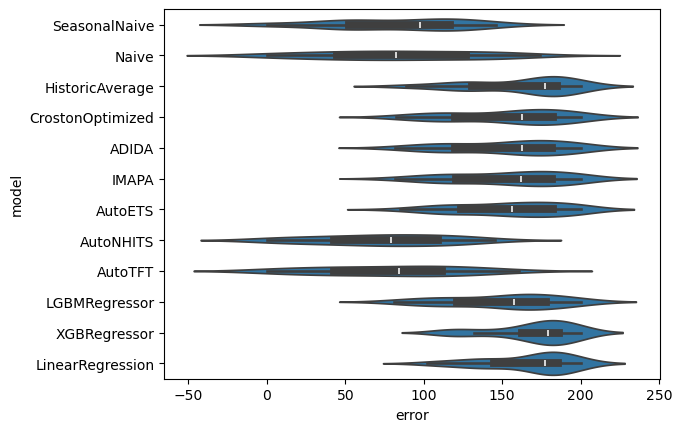

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

### Choose models for groups of series

Feature: 

* A unified dataframe with forecasts for all different models
* Easy Ensamble
* E.g. Average predictions
* Or MinMax (Choosing is ensembling)

<Axes: xlabel='n', ylabel='best_model'>

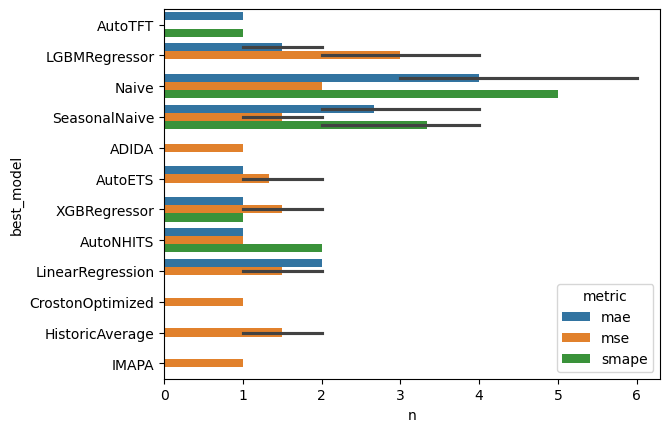

In [ ]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

### Et pluribus unum: an inclusive forecasting Pie.

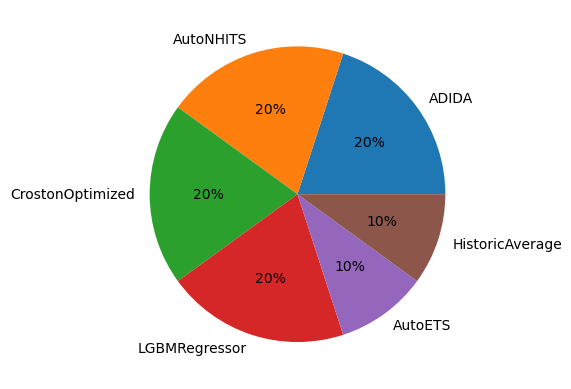

In [ ]:
# For the mse, calculate how many times a model wins
eval_series_df = evaluation_df.query('metric == "mse"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)
counts_series = eval_series_df.value_counts('best_model')
plt.pie(counts_series, labels=counts_series.index, autopct='%.0f%%')
plt.show()

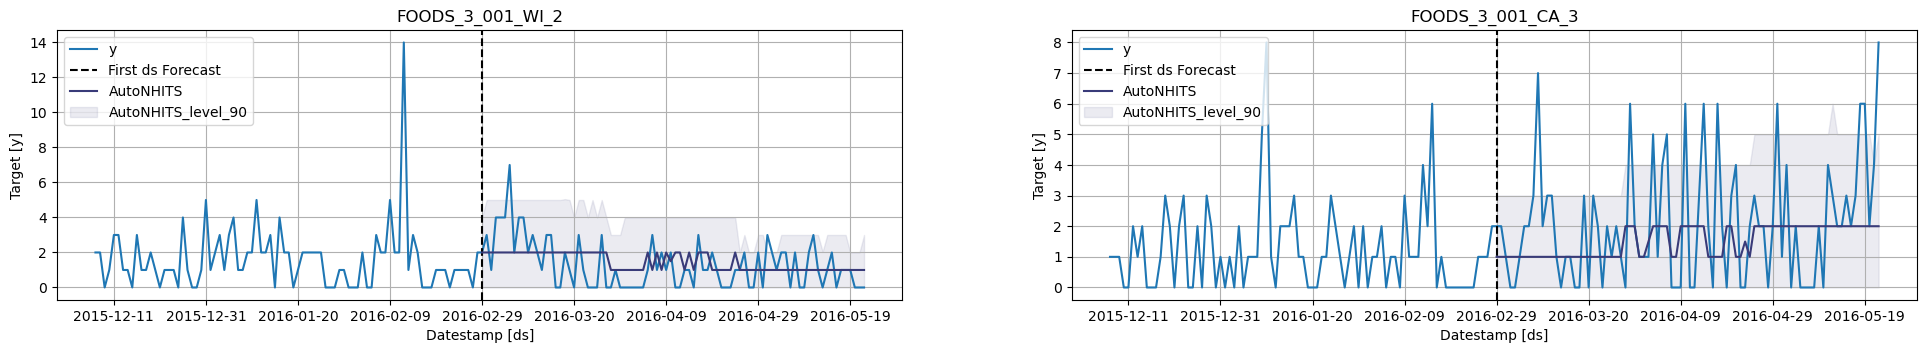

In [ ]:
sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=28 * 6, 
        models=['AutoNHITS'],
        unique_ids=eval_series_df.query('best_model == "AutoNHITS"').index[:8])

# Choose Forecasting method for different groups of series

In [ ]:
# Merge the best model per time series dataframe
# and filter the forecasts based on that dataframe
# for each time series
fcst_df = pd.melt(fcst_df.set_index('unique_id'), id_vars=['ds'], var_name='model', value_name='forecast', ignore_index=False)
fcst_df = fcst_df.join(eval_series_df[['best_model']])
fcst_df[['model', 'pred-interval']] = fcst_df['model'].str.split('-', expand=True, n=1)
fcst_df = fcst_df.query('model == best_model')
fcst_df['name'] = [f'forecast-{x}' if x is not None else 'forecast' for x in fcst_df['pred-interval']]
fcst_df = pd.pivot_table(fcst_df, index=['unique_id', 'ds'], values=['forecast'], columns=['name']).droplevel(0, axis=1).reset_index()

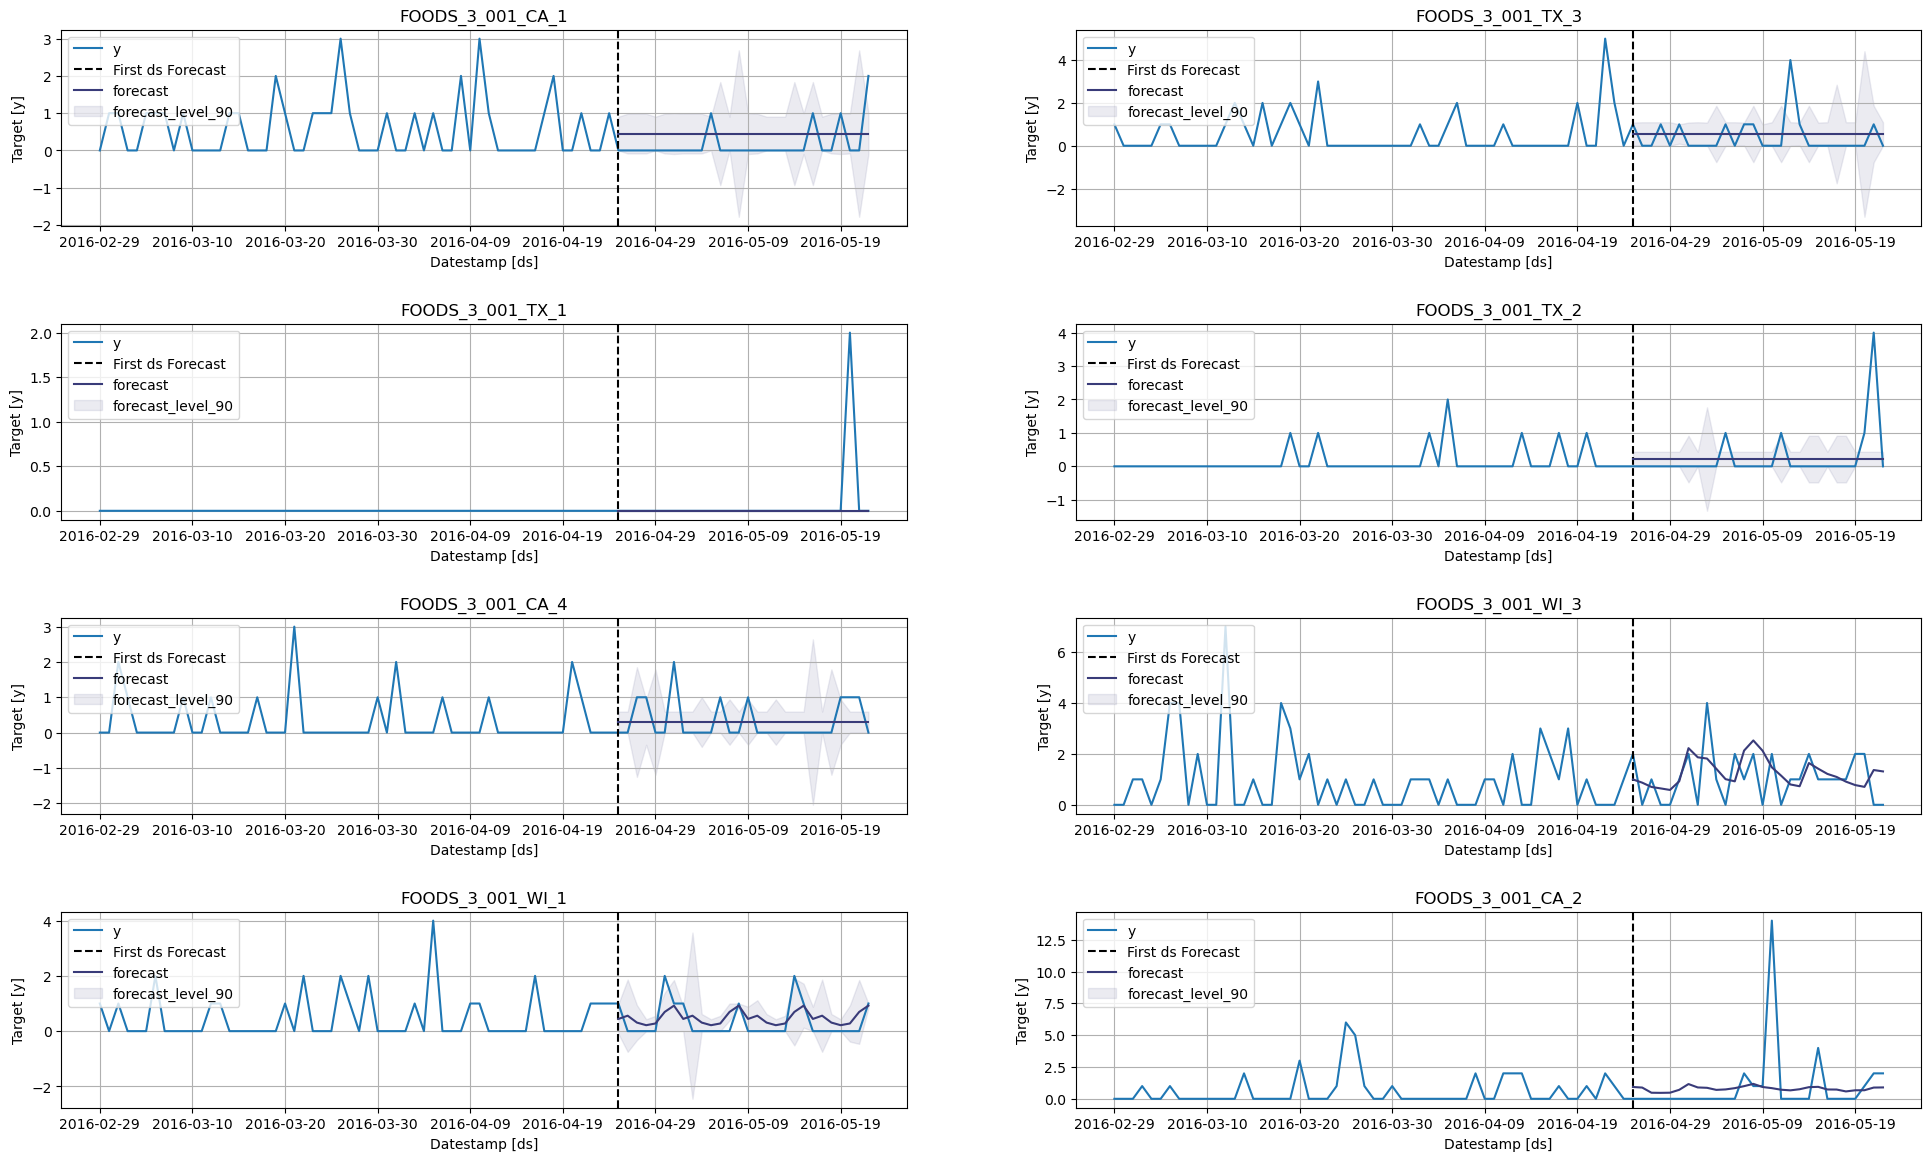

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

# Technical Debt

- Train the statistical models in the full dataset.
- Increase the number of `num_samples` in the neural auto models.
- Include other models such as `Theta`, `ARIMA`, `RNN`, `LSTM`, ...

# Further materials

- [Available Models StatsForecast](https://nixtla.github.io/statsforecast/examples/models_intro.html)
- [Available Models NeuralForecast](https://nixtla.github.io/neuralforecast/models.html)
- [Scalers and Loss Functions](https://nixtla.github.io/neuralforecast/losses.pytorch.html)
- [Getting Started NeuralForecast](https://nixtla.github.io/neuralforecast/examples/getting_started.html)
- [Hierarchical Reconciliation](https://nixtla.github.io/hierarchicalforecast/examples/tourismsmall.html)
- [Distributed ML Forecast (trees)](https://nixtla.github.io/mlforecast/docs/quick_start_distributed.html)
- [Using StatsForecast to train millions of time series](https://www.anyscale.com/blog/how-nixtla-uses-ray-to-accurately-predict-more-than-a-million-time-series)
- [Intermittent Demand Forecasting With Nixtla on Databricks](https://www.databricks.com/blog/2022/12/06/intermittent-demand-forecasting-nixtla-databricks.html)